# Build regression model from formation signals

Create a simple linear regression model that maps formation signals to end-of-life features.

Created: 4/18/2021

Author: Andrew Weng

In [1]:
import os, sys

if os.path.basename(os.getcwd()) == 'code':
    os.chdir('../')
sys.path.append('code')

import numpy as np
import pandas as pd

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
from matplotlib import pyplot as plt

from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import ipdb

from src.formation import FormationCell
from src.utils import get_label_registry

# Make sure user is in the right directory
assert os.path.basename(os.getcwd()) == 'project-formation'

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

In [3]:
# Configure plot settings
plt.rc('font', **{'family'     : 'sans-serif',
                  'sans-serif' : ['Arial'],
                  'size': 18
                  })
plt.rc('figure', **{'autolayout' : True,
                    'figsize'    : (7, 5),
                    'facecolor'  : 'white',
                    'dpi'        : 150
                    })
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')
plt.rc('axes',  labelsize='medium', grid=False)
plt.rc('axes',  titlesize='medium')
plt.rc('legend', fontsize='medium')

cmap = cm.get_cmap('Set1', 10)

In [4]:
# Formation types
CELL_BASE = 7
CELL_FAST = 33
COLOR_BASE = 'k'
COLOR_FAST = np.array([44, 121, 245])/255
COLOR_FAST_RT = 'b'
COLOR_FAST_HT = 'r'
LINESTYLE_BASE = ':'
LINESTYLE_FAST = '-'

# Pos/neg electrode colors
COLOR_POS = 'b'
COLOR_NEG = 'r'
COLOR_FULL_CELL = 'k'

COLOR_REF = (0.7, 0.7, 0.7)

NOMINAL_CAPACITY_AH = 2.36
CAPACITY_LIMITS_AH = (0.8, 2.4)
TARGET_RETENTION = 0.7

## Point to the dataset

In [5]:
DATA_INPUT_PATH = 'output/2021-03-fast-formation-esoh-fits/correlation_data.csv';

assert os.path.isfile(DATA_INPUT_PATH), "Input data file is missing or is in the wrong directory."

## Load the correlation data

In [6]:
df = pd.read_csv(DATA_INPUT_PATH)

df = df[df['cellid'] != 9] # tab weld issue cell; exclude from entire study

# A single cell had a blatantly unphysical voltage fitting result; exclude this
df['esoh_c3_Cn'][df['esoh_c3_Cn'] > 3] = np.nan 
df['esoh_c3_CnCp'][df['esoh_c3_CnCp'] > 1.2] = np.nan 

# Cycle indices corresponding to RPTs, plus one at the beginning for "formation"
cyc_idx_rpt_arr = [1, 3, 56, 159, 262, 365]

# Keep only high temperature data / ignore room temperature data
df = df[df['is_room_temp_aging'] == 0]

# Here are the available features
for feature in sorted(df.columns):
    print(feature)

Unnamed: 0
cellid
channel_number
cycles_to_50_pct
cycles_to_60_pct
cycles_to_70_pct
cycles_to_80_pct
dcr_10s_0_soc_at_c100
dcr_10s_0_soc_at_c150
dcr_10s_0_soc_at_c159
dcr_10s_0_soc_at_c200
dcr_10s_0_soc_at_c250
dcr_10s_0_soc_at_c262
dcr_10s_0_soc_at_c3
dcr_10s_0_soc_at_c300
dcr_10s_0_soc_at_c350
dcr_10s_0_soc_at_c365
dcr_10s_0_soc_at_c400
dcr_10s_0_soc_at_c450
dcr_10s_0_soc_at_c50
dcr_10s_0_soc_at_c56
dcr_10s_100_soc_at_c100
dcr_10s_100_soc_at_c150
dcr_10s_100_soc_at_c159
dcr_10s_100_soc_at_c200
dcr_10s_100_soc_at_c250
dcr_10s_100_soc_at_c262
dcr_10s_100_soc_at_c3
dcr_10s_100_soc_at_c300
dcr_10s_100_soc_at_c350
dcr_10s_100_soc_at_c365
dcr_10s_100_soc_at_c400
dcr_10s_100_soc_at_c450
dcr_10s_100_soc_at_c50
dcr_10s_100_soc_at_c56
dcr_10s_10_soc_at_c100
dcr_10s_10_soc_at_c150
dcr_10s_10_soc_at_c159
dcr_10s_10_soc_at_c200
dcr_10s_10_soc_at_c250
dcr_10s_10_soc_at_c262
dcr_10s_10_soc_at_c3
dcr_10s_10_soc_at_c300
dcr_10s_10_soc_at_c350
dcr_10s_10_soc_at_c365
dcr_10s_10_soc_at_c400
dcr_10s_10_s

<ipython-input-6-c265eae0e8c6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['esoh_c3_Cn'][df['esoh_c3_Cn'] > 3] = np.nan
<ipython-input-6-c265eae0e8c6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['esoh_c3_CnCp'][df['esoh_c3_CnCp'] > 1.2] = np.nan


## Define the models

In [7]:
def build_model(X, y, model=None):
    """
    Build univariate linear regression model with the given datapoints
    
    Inputs:
      X: inputs (n)
      y: outputs
      
    Returns a tuple holding the model and the correlation coefficient
    """
    
    # Default to LinearRegression
    model = model or LinearRegression()
    
    # map function applies the function to all rows of X.T i.e. all columns of X
    corrs = map(lambda x: pearsonr(x.flatten(), y.flatten())[0], X.T)
    
    model.fit(X, y)
    
    return (model, tuple(corrs))
    
# Test
X = df[["var_q_c365_c3", "var_q_c56_c3", "var_q_c159_c3"]].values
y = df['cycles_to_80_pct'].values
model, corrs = build_model(X,y)
print(corrs)
model.score(X,y)

(-0.8700643439079858, -0.5742942233893628, -0.515878958670716)


0.7759259567826146

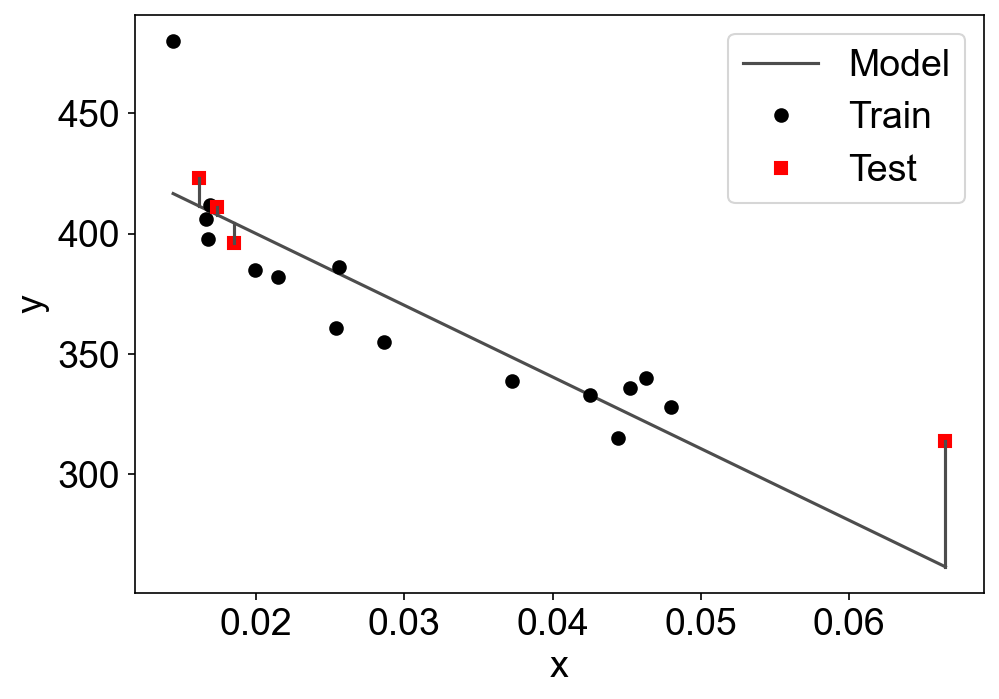

{'model': LinearRegression(),
 'rmse': 32.658422975146024,
 'rmse_std': 15.219853166373403,
 'corr': (-0.8791980297486647, -0.588198367423439, -0.5384203536433756),
 'corr_std': (0.02905871425119146, 0.10042843501904698, 0.13919782969027747),
 'percent_error': 6.586279779385487,
 'percent_error_std': 2.784679057705148,
 'r2_score': -0.9163155603359177,
 'r2_score_std': 3.8575104913259137,
 'xvar': ('var_q_c365_c3', 'var_q_c56_c3', 'var_q_c159_c3')}

In [8]:
def train_and_test_model(df, xvars, yvar, to_plot=1):
    """
    Train and test a univariate linear regression model with cross-validation
    
    Args:
      df is a Pandas DataFrame object
      xvars is a list of strings (the feature names)
      yvar is a string (the label name)
      to_plot : make debug plots if true
      
    Returns:
      a dictionary holding model outputs
    """    
    # Fraction of samples reserved for model testing
    # e.g. 0.2 means 20% of samples reserved. In the 
    # context of cross-validation, this would be 
    # equivalent to a 5-fold cross-validation. The 
    # cross-validation we end up doing is not exactly
    # 5-fold cross-validation since we introduce random
    # sampling and many many repeats
    TEST_SIZE = 0.2
    
    # Number of trials
    NUM_EXPERIMENTS = 100
    
    # Unpack and filter data
    xvars = [xvars] if isinstance(xvars, str) else xvars
    # Create a temporary df to filter NaNs only from the columns we use
    xyvars = xvars + [yvar]
    df_nonans = df[xyvars].dropna()
    
    X = df_nonans[xvars].values
    y = df_nonans[yvar].values
        
    percent_error_list = []
    r2_score_list = []
    rmse_list = []
    intercept_list = []
    coef_list = []
    corr_list = []
    
    has_plotted = 0
    
    for idx in range(NUM_EXPERIMENTS):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=TEST_SIZE)

        # todo: apply standard scaler
    
        (model, corr) = build_model(X_train, y_train)
        
        y_pred = model.predict(X_test)

        rmse = np.sqrt(np.mean((y_pred - y_test)**2))    
        percent_error = np.mean(np.abs(y_pred - y_test)/y_test) * 100
        r2_score = model.score(X_test, y_test)
        
        rmse_list.append(rmse)
        percent_error_list.append(percent_error)
        r2_score_list.append(r2_score)
        intercept_list.append(model.intercept_)
        coef_list.append(model.coef_)
        corr_list.append(corr)
    
        # Give a visual into the cross-validation process
        baseline_rmse = np.sqrt(np.mean((y_test - np.mean(y_test))**2))
        if to_plot and not has_plotted and X.shape[1] == 1:# and baseline_rmse < rmse:
#             print(r2_score, rmse, baseline_rmse)
            has_plotted = 1
            
            X_fit = np.linspace(np.min(X), np.max(X), 100)
            y_fit = model.predict(X_fit.reshape(-1, 1))
            plt.plot(X_fit, y_fit, color=(0.3, 0.3, 0.3))
            plt.plot(X_train, y_train, 'o', color='k')
            plt.plot(X_test, y_test, 's', color='r')
            
            for (this_x, this_y) in zip(X_test, y_test):
                plt.plot([this_x, this_x], 
                         [this_y, model.predict([this_x])[0]], 
                         label='', color=(0.3, 0.3, 0.3))
                
            plt.xlabel('x')
            plt.ylabel('y')
            plt.legend(['Model', 'Train', 'Test'])
            plt.show()
    
    # Package the output
    final_model = model
    final_model.coef_ = np.array([np.mean(coef_list)], dtype="object")
    final_model.intercept_ = np.mean(intercept_list)
        
    final_rmse = np.mean(rmse_list)
    final_rmse_std = np.std(rmse_list)
    
    # Column mean and column std of a list of tuples
    final_corr = tuple(map(np.mean, zip(*corr_list)))
    final_corr_std = tuple(map(np.std, zip(*corr_list)))
    
    final_percent_error = np.mean(percent_error_list)
    final_percent_error_std = np.std(percent_error_list)
    
#     print(len(r2_score_list), sum(np.array(r2_score_list)>0))
    final_r2_score = np.mean(r2_score_list)
    final_r2_score_std = np.std(r2_score_list)
    
    model_output_dict = dict()
    model_output_dict['model'] = final_model
    model_output_dict['rmse'] = final_rmse
    model_output_dict['rmse_std'] = final_rmse_std
    model_output_dict['corr'] = final_corr
    model_output_dict['corr_std'] = final_corr_std
    model_output_dict['percent_error'] = final_percent_error
    model_output_dict['percent_error_std'] = final_percent_error_std
    model_output_dict['r2_score'] = final_r2_score
    model_output_dict['r2_score_std'] = final_r2_score_std
    model_output_dict['xvar'] = tuple(xvars)
    
    return model_output_dict

# Test
# one feature
train_and_test_model(df, 
                     "var_q_c365_c3", 
                     'cycles_to_80_pct', 
                     to_plot=1)
# multiple features
train_and_test_model(df, 
                     ["var_q_c365_c3", "var_q_c56_c3", "var_q_c159_c3"], 
                     'cycles_to_80_pct', 
                     to_plot=1)

# Single variable analysis

## Set up and fit/predict/score

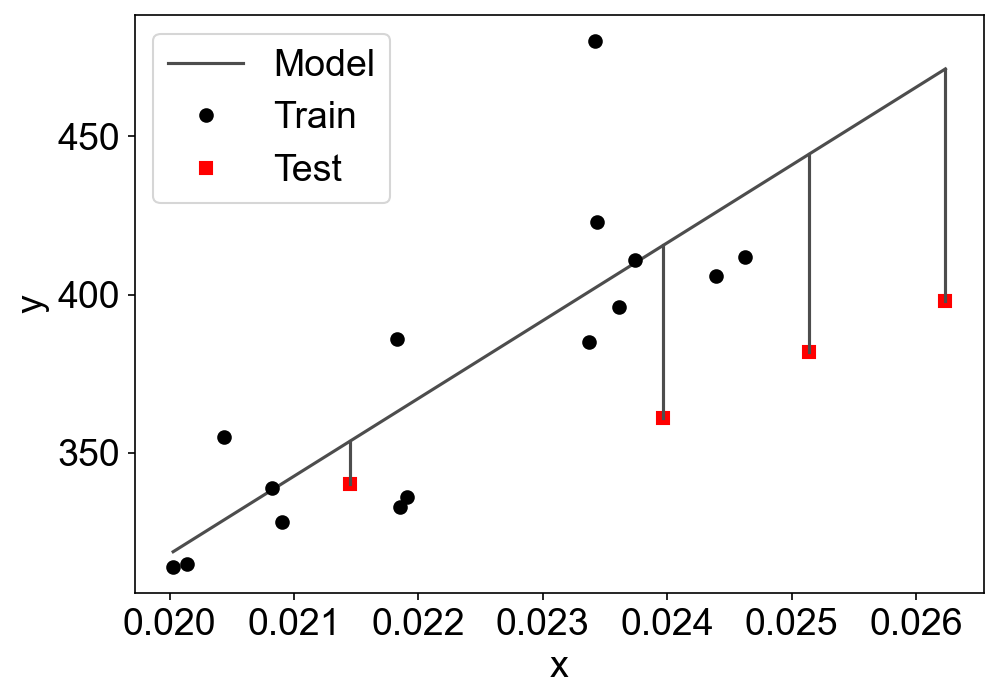

In [9]:
# Set the y-variable (the output the model is trying to predict)
yvar = 'cycles_to_80_pct'

# Gather a list of modeled results. 
# Each element of the list holds all modeled results for a particular cycle
results_list = []

# First take care of the formation delta V signal, which only exists for the initial cycle
xvar = 'form_6hr_rest_delta_voltage_v'

model_output_dict = train_and_test_model(df, xvar, yvar)
model = model_output_dict['model']

results_dict = dict()
results_dict['cycle_index'] = 0 #
results_dict[xvar] = model_output_dict

results_list.append(results_dict)

Working on cycle 3...


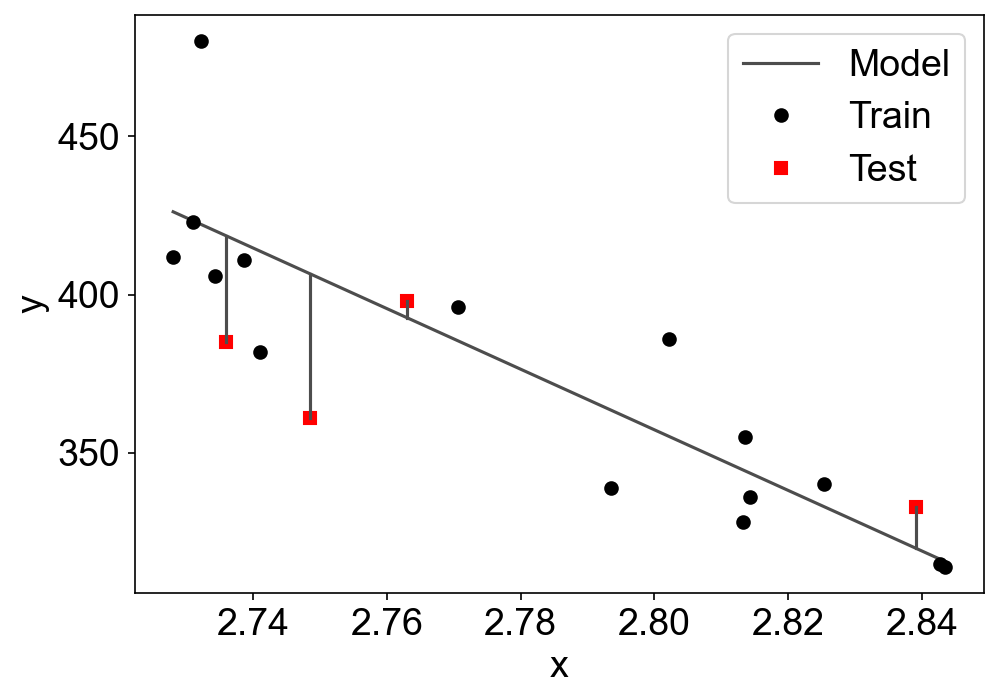

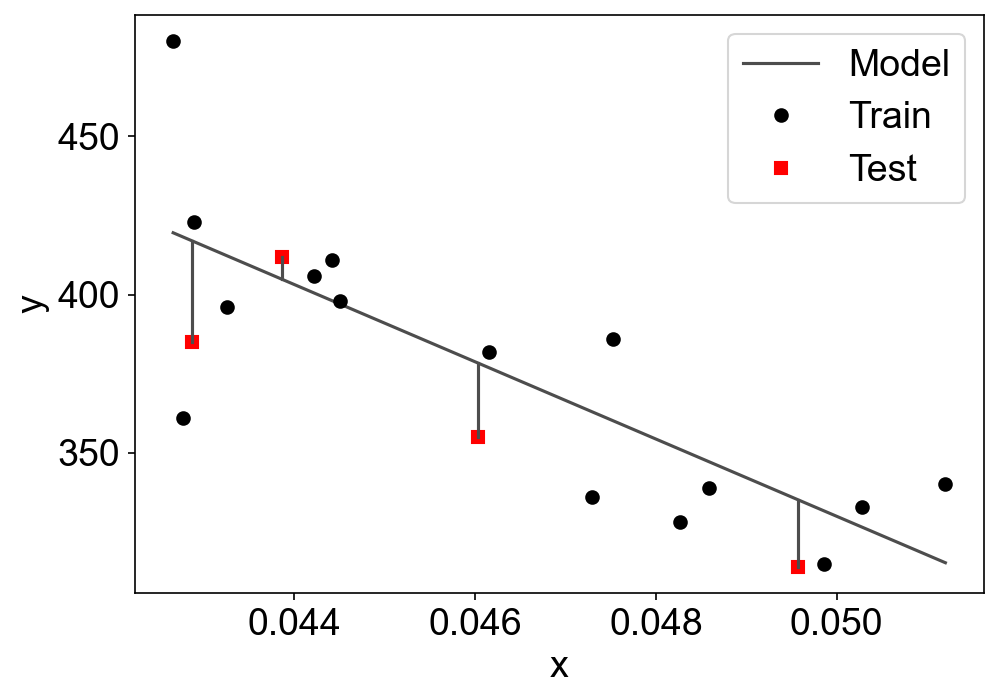

Working on cycle 56...


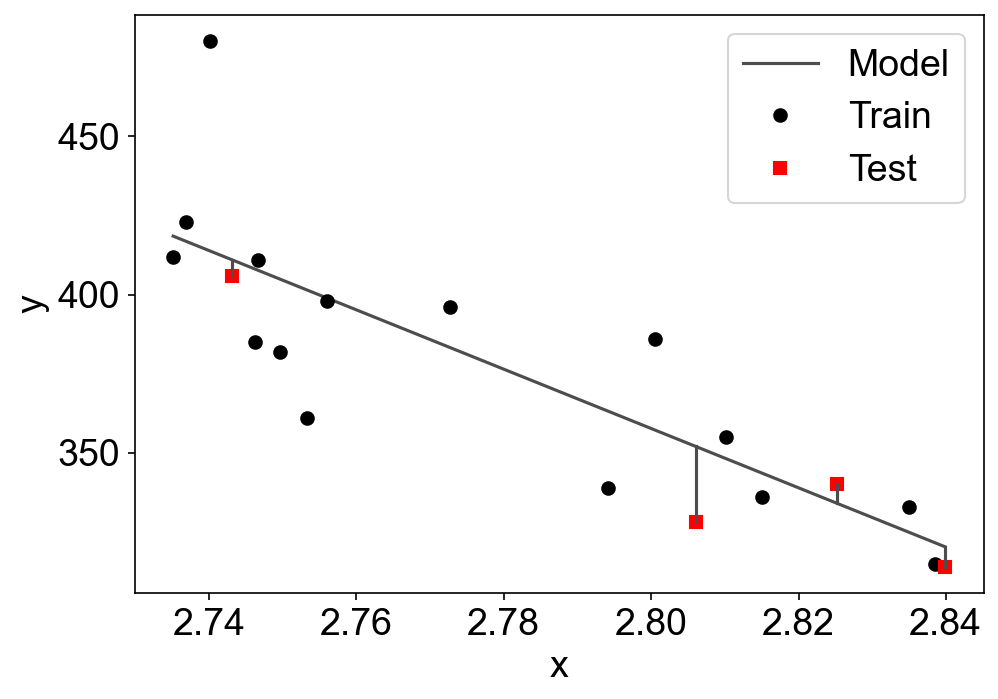

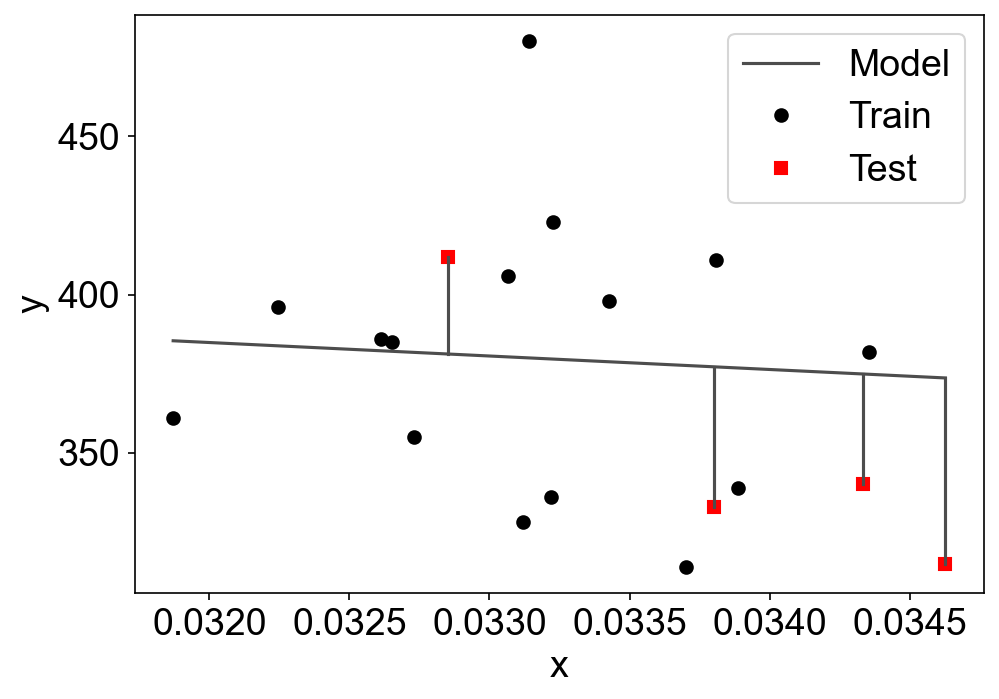

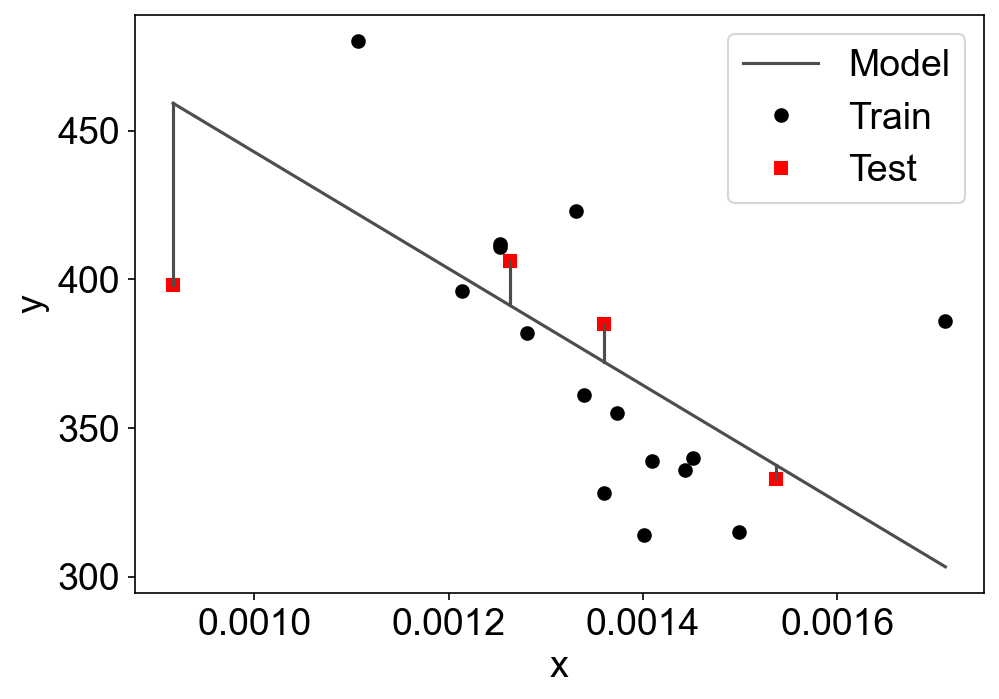

Working on cycle 159...


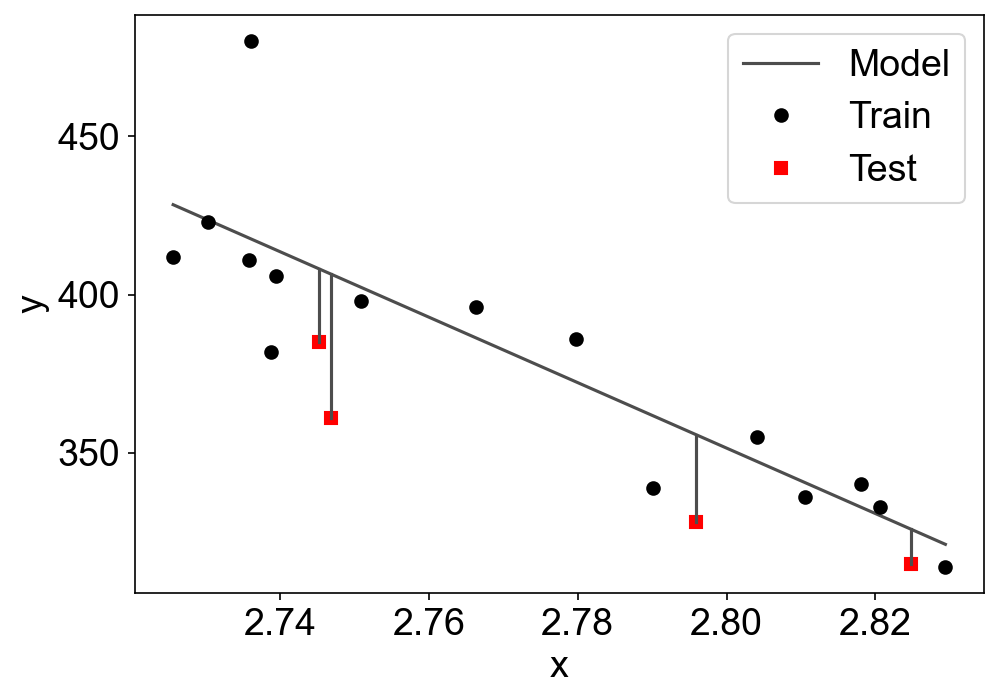

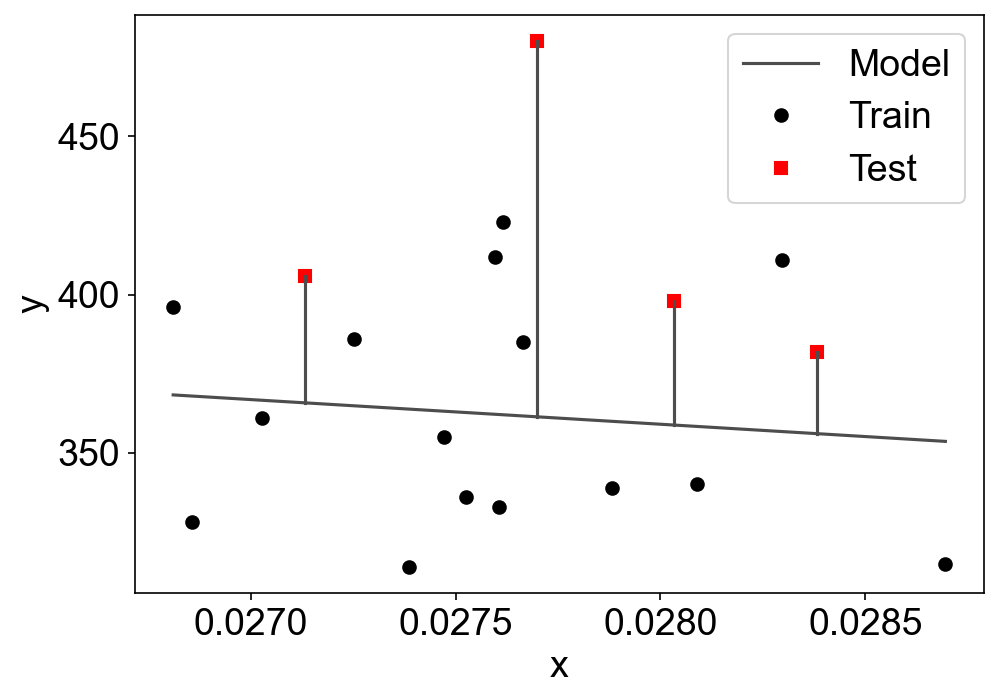

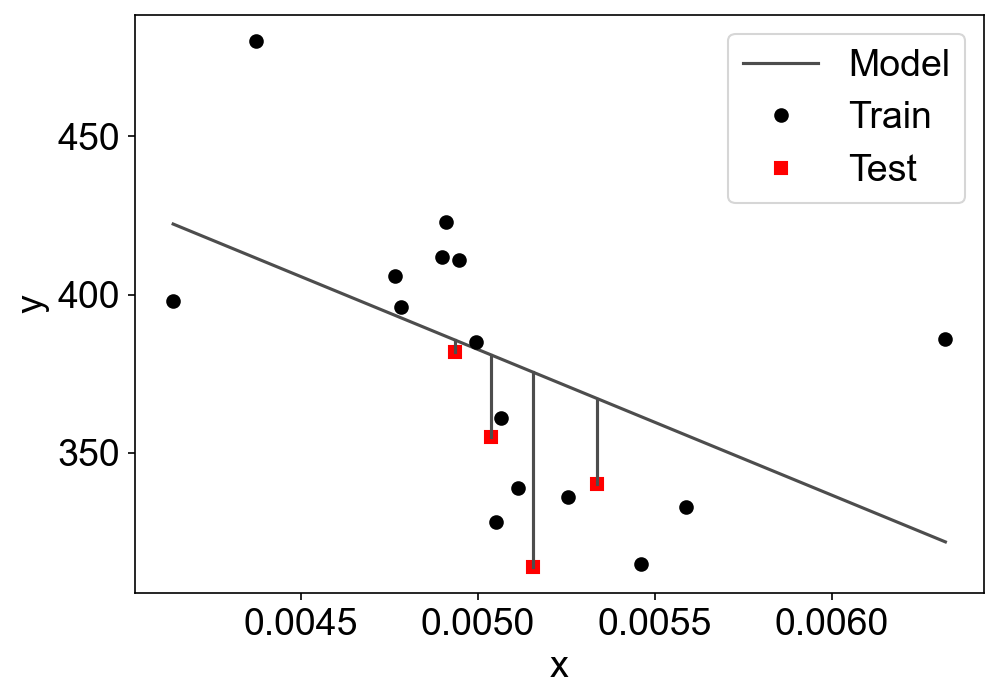

Working on cycle 262...


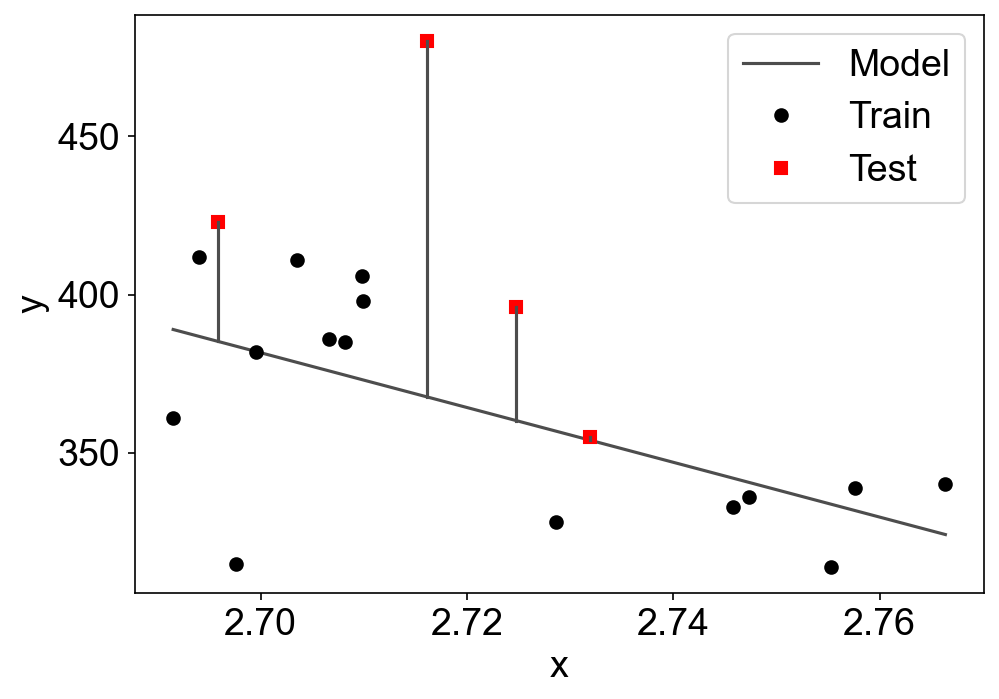

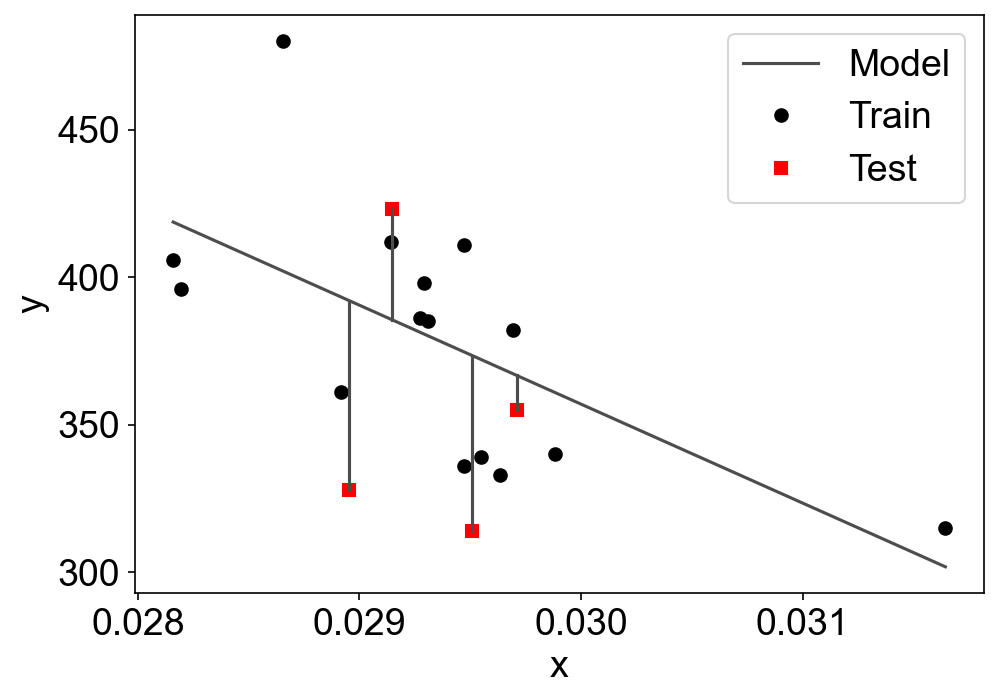

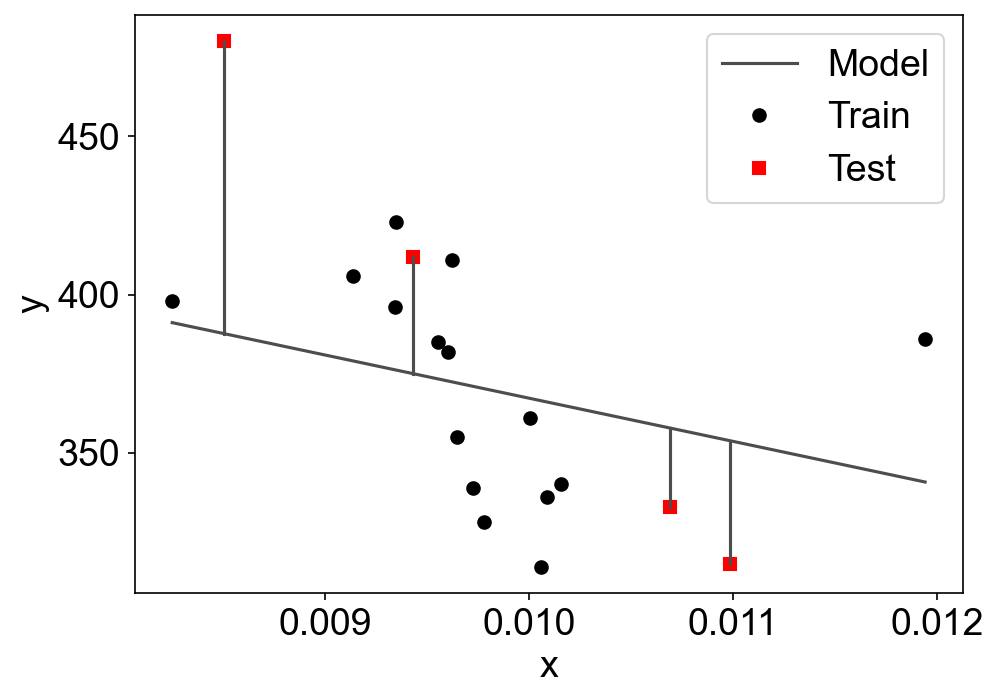

Working on cycle 365...


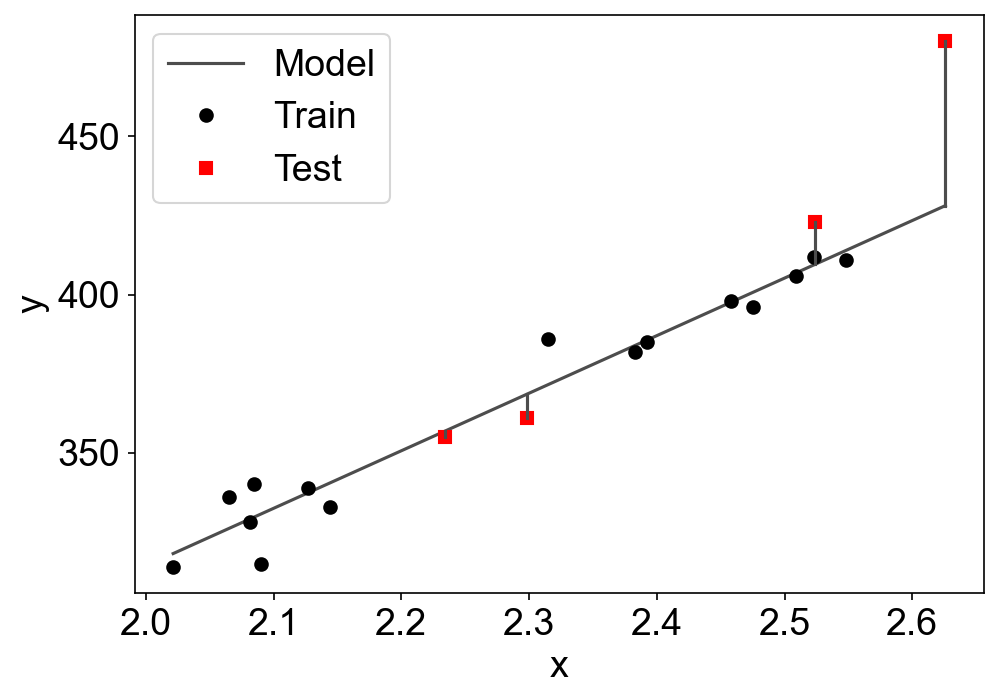

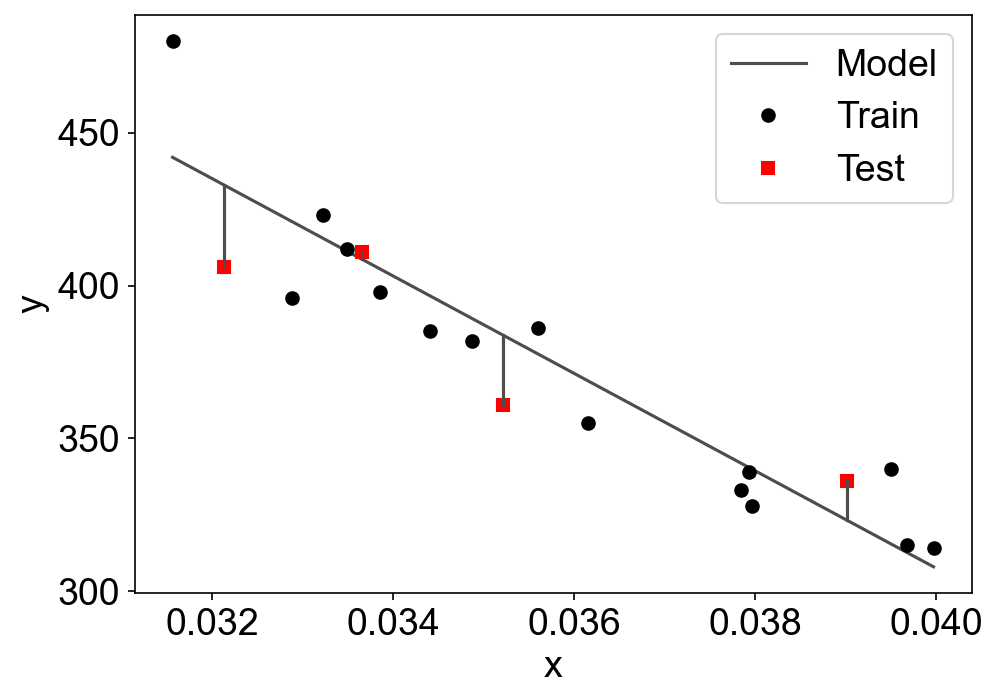

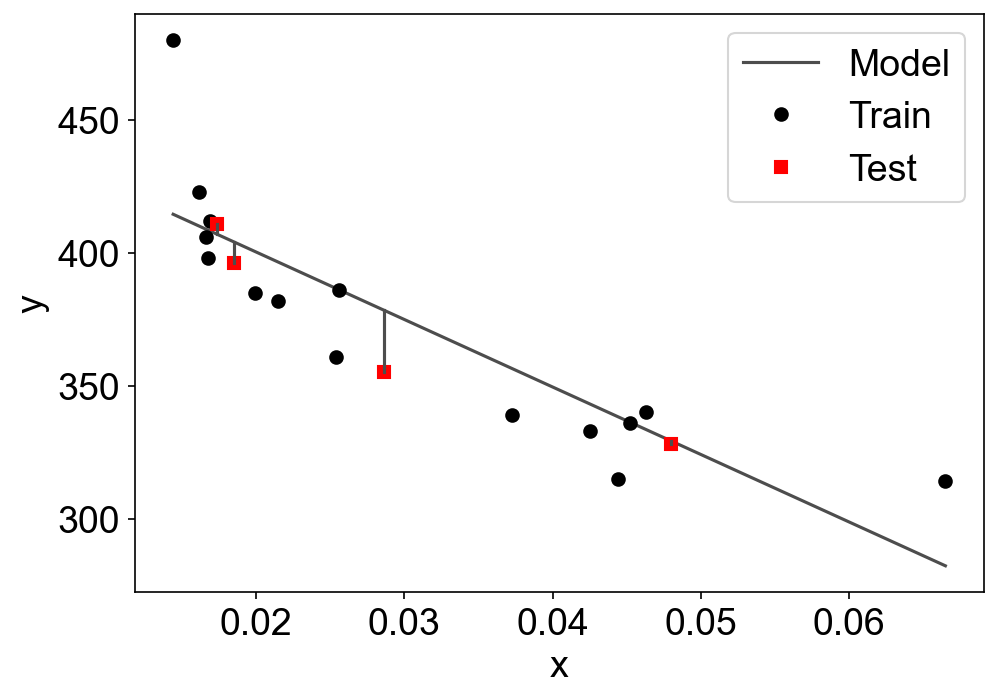

Done.


In [10]:
# Now take care of the rest of the signals. These signals exist for multiple cycles since 
# they exist at each RPT. So we will loop through the valid cycle indices and repeat this 
# process.

cycle_target_list = [3, 56, 159, 262, 365]

for cycle_idx in cycle_target_list:
    
    print(f'Working on cycle {cycle_idx}...')
    
    # Assemble x variables of interest
    xvar_array = [f'esoh_c{cycle_idx}_Cn',
                  f'dcr_10s_5_soc_at_c{cycle_idx}',
                  f'var_q_c{cycle_idx}_c3']
    
    results_dict = dict()
    results_dict['cycle_index'] = cycle_idx
    
    # Loop over x-variables
    for xvar in xvar_array:

        if not xvar in df.columns:
            continue
        
        model_output_dict = train_and_test_model(df, xvar, yvar)
        
        model = model_output_dict['model']

        if '_Cn' in xvar:
            xvar_label = 'Cn'
        if 'dcr_10s_5_soc' in xvar:
            xvar_label = 'dcr_10s_5_soc'
        if 'var_q' in xvar:
            xvar_label = 'var_q'
    
        results_dict[xvar_label] = model_output_dict
        
    results_list.append(results_dict)      
    
print('Done.')
    

Take a look at the results list variable.

It is a list of dictionaries. Each dictionary holds the output for a single cycle index.

In [11]:
results_list

[{'cycle_index': 0,
  'form_6hr_rest_delta_voltage_v': {'model': LinearRegression(),
   'rmse': 28.471146623418175,
   'rmse_std': 11.784846473261503,
   'corr': (0.6938355878839277,),
   'corr_std': (0.05165478880209947,),
   'percent_error': 6.3353688378364375,
   'percent_error_std': 2.1608945151761447,
   'r2_score': -0.2466298107556328,
   'r2_score_std': 1.7383160075297308,
   'xvar': ('form_6hr_rest_delta_voltage_v',)}},
 {'cycle_index': 3,
  'Cn': {'model': LinearRegression(),
   'rmse': 22.719892701087765,
   'rmse_std': 10.152588349351031,
   'corr': (-0.8492149562897418,),
   'corr_std': (0.03388116457659918,),
   'percent_error': 4.943987678972372,
   'percent_error_std': 1.851811501429369,
   'r2_score': 0.19628032035519655,
   'r2_score_std': 0.899577109325467,
   'xvar': ('esoh_c3_Cn',)},
  'dcr_10s_5_soc': {'model': LinearRegression(),
   'rmse': 27.21974494450123,
   'rmse_std': 11.13976085932746,
   'corr': (-0.8044572331705676,),
   'corr_std': (0.03821002114753247,)

## Re-package the data to become easily plottable

Repackage the data to index by feature, which makes it easier for plotting.

There is probably a more "pandas-y" way to do this.

In [12]:
# Get a list of unique x-variable labels
unique_keys = set()
for result_dict in results_list:
    for key in result_dict.keys():
        unique_keys.add(key)
unique_keys.remove('cycle_index')

# Assemble the outputs into a dictionary
output_dict = dict()
for key in unique_keys:
    
    cycle_list = []
    rmse_list = []
    rmse_std_list = []
    corr_list = []
    corr_std_list = []
    percent_error_list = []
    percent_error_std_list = []
    
    for result_dict in results_list:

        cycle_list.append(result_dict['cycle_index'])    
        
        if not key in result_dict:
            rmse_list.append(np.nan)
            rmse_std_list.append(np.nan)
            corr_list.append(np.nan)
            corr_std_list.append(np.nan)
            percent_error_list.append(np.nan)
            percent_error_std_list.append(np.nan)
            continue

        rmse_list.append(result_dict[key]['rmse'])
        rmse_std_list.append(result_dict[key]['rmse_std'])
        if len(result_dict[key]['corr']) == 1:
            corr_list.append(result_dict[key]['corr'][0])
            corr_std_list.append(result_dict[key]['corr_std'][0])
        percent_error_list.append(result_dict[key]['percent_error'])
        percent_error_std_list.append(result_dict[key]['percent_error_std'])
        
        
    this_result = dict()
    this_result['cycle_index'] = cycle_list
    this_result['rmse'] = rmse_list
    this_result['rmse_std'] = rmse_std_list
    this_result['corr'] = corr_list
    this_result['corr_std'] = corr_std_list
    this_result['percent_error'] = percent_error_list
    this_result['percent_error_std'] = percent_error_std_list
    
    output_dict[key] = this_result
    
# The output dictionary is now indexed by feature
output_dict

{'form_6hr_rest_delta_voltage_v': {'cycle_index': [0, 3, 56, 159, 262, 365],
  'rmse': [28.471146623418175, nan, nan, nan, nan, nan],
  'rmse_std': [11.784846473261503, nan, nan, nan, nan, nan],
  'corr': [0.6938355878839277, nan, nan, nan, nan, nan],
  'corr_std': [0.05165478880209947, nan, nan, nan, nan, nan],
  'percent_error': [6.3353688378364375, nan, nan, nan, nan, nan],
  'percent_error_std': [2.1608945151761447, nan, nan, nan, nan, nan]},
 'dcr_10s_5_soc': {'cycle_index': [0, 3, 56, 159, 262, 365],
  'rmse': [nan,
   27.21974494450123,
   40.09768847108808,
   47.82181271551937,
   36.78958148126061,
   17.502943627174673],
  'rmse_std': [nan,
   11.13976085932746,
   11.659155508396823,
   14.119374121199202,
   11.07887233231206,
   7.236612823881063],
  'corr': [nan,
   -0.8044572331705676,
   -0.31921996718524553,
   -0.033197850953662324,
   -0.5628624574871083,
   -0.9323703644847143],
  'corr_std': [nan,
   0.03821002114753247,
   0.0895820526295287,
   0.118065163720252

## Visualize the results

In [13]:
# Create another dictionary of labels
label_dict = dict()
label_dict['var_q'] = '$\Delta Q$'
label_dict['Cn'] = '$C_n$'
label_dict['dcr_10s_5_soc'] = '$R_{10s, 5\%SOC}$'
label_dict['form_6hr_rest_delta_voltage_v'] = '$\Delta V_{rest, 6hr}$'

<Figure size 1050x750 with 0 Axes>

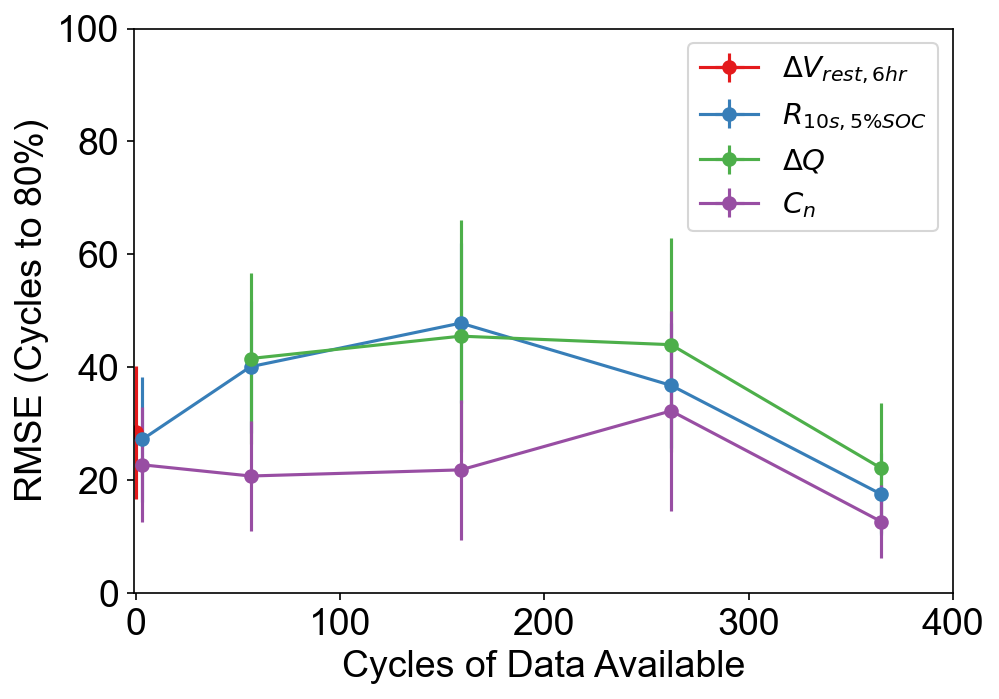

<Figure size 1050x750 with 0 Axes>

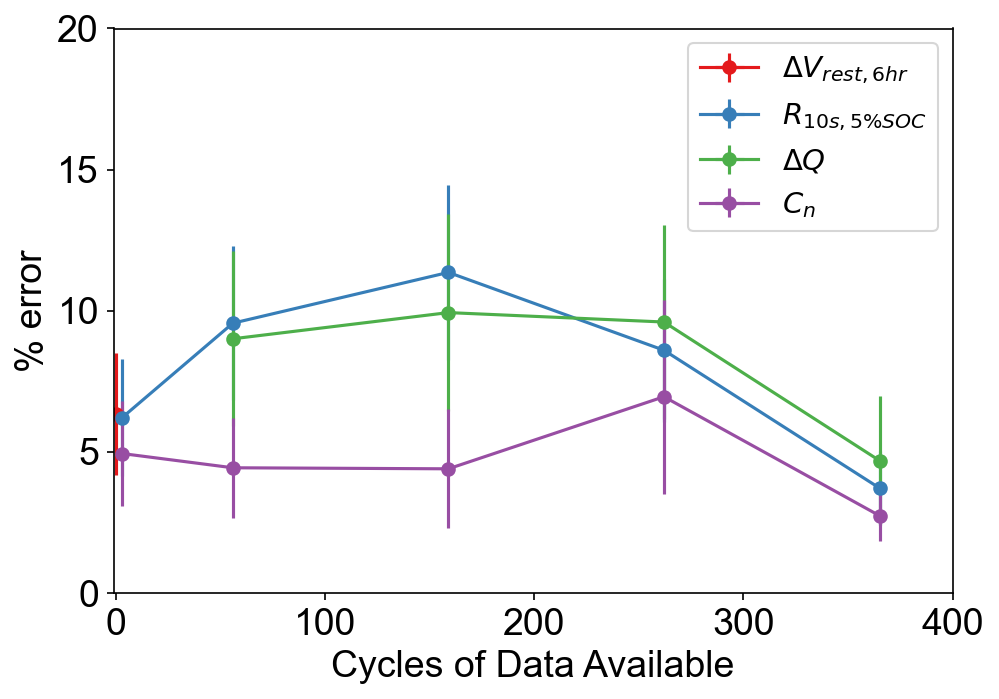

<Figure size 1050x750 with 0 Axes>

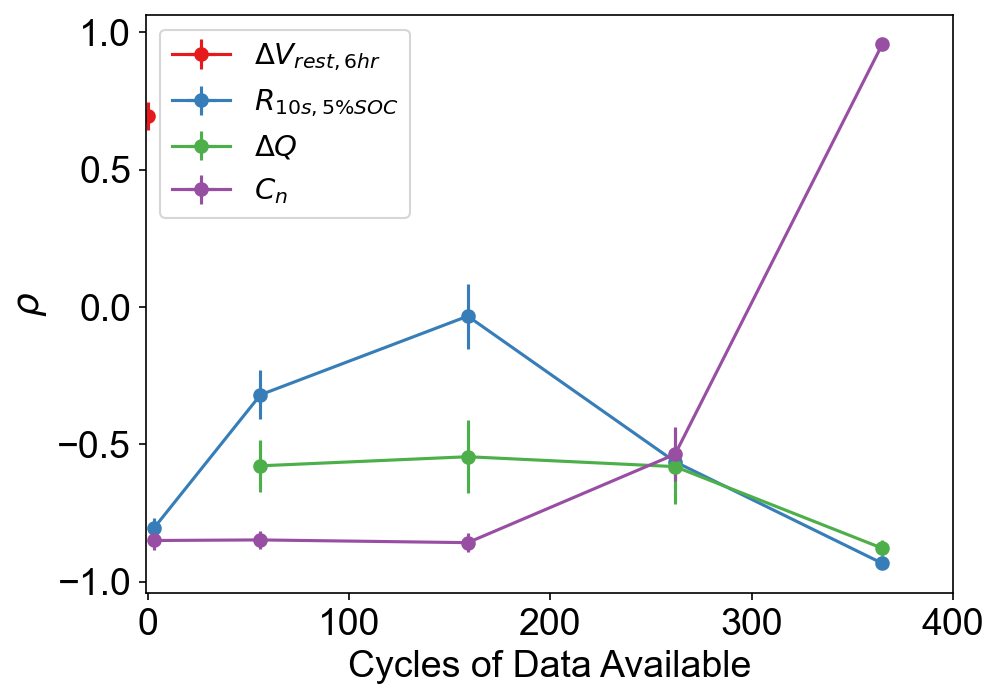

In [14]:
# Unpack and plot the dictionary of outputs
plt.figure()
fig, ax = plt.subplots()

labels = ["c%.0f" % number for number in output_dict[list(output_dict.keys())[0]]['cycle_index']]
labels[0] = "         Form."
    
# RMSE error (cycles to 70%)
for idx, key in enumerate(output_dict):

    x = output_dict[key]['cycle_index']
    y = output_dict[key]['rmse']
    error = output_dict[key]['rmse_std']
    
    ax.errorbar(x, y, xerr=0, yerr=error, fmt='-o', 
                label=label_dict[key], color=cmap(idx))

plt.xlabel('Cycles of Data Available')
plt.ylabel('RMSE (Cycles to 80%)')
plt.xlim((-1, 400))
plt.ylim((0, 100))
plt.legend(fontsize=14)

# Percent error
plt.figure()
fig, ax = plt.subplots()

for idx, key in enumerate(output_dict):
    
    x = output_dict[key]['cycle_index']
    y = output_dict[key]['percent_error']
    error = output_dict[key]['percent_error_std']
    
    ax.errorbar(x, y, xerr=0, yerr=error, fmt='-o', 
                label=label_dict[key], color=cmap(idx))

plt.xlabel('Cycles of Data Available')
plt.ylabel('% error')
plt.ylim((0, 20))
plt.xlim((-1, 400))
plt.legend(fontsize=14)


# Correlation coefficient evolution
plt.figure()
fig, ax = plt.subplots()

for idx, key in enumerate(output_dict):
    
    x = output_dict[key]['cycle_index']
    y = output_dict[key]['corr']
    error = output_dict[key]['corr_std']
    
    ax.errorbar(x, y, xerr=0, yerr=error, fmt='-o', 
                label=label_dict[key], color=cmap(idx))

plt.xlabel('Cycles of Data Available')
plt.ylabel(r'$\rho$')
plt.xlim((-1, 400))
plt.legend(fontsize=14)